In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


# 15.1 순환 뉴런과 순환 층

* 순환 신경망은 피드포워드 신경망과 매우 비슷하지만 뒤쪽으로 순환하는 연결도 있다는 점이 다르다.
<img src = "images/15_images/rnn02.png">
* 입력을 받아 출력을 만들고 자신에게도 출력을 보내는 뉴런 하나로 구성된 RNN
 - 각 타임 스텝(Time Step) 또는 프레임(Frame)마다 이 순환 뉴런(Recurrent Neuron)은 일반적인 입력과 이전 타임 스텝의 출력을 입력으로 같이 받는다.
 - 첫 번재 타임 스텝에서는 이전 출력이 없으므로 일반적으로 0으로 설정한다.
 - 이 작은 네트워크를 오른쪽처럼 시간을 축으로 하여 표현할 수 있다. 이를 시간에 따라 네트워크를 펼쳤다.(Unrolling the network through time)고 말한다.
<img src="images/15_images/rnn03.png">
* 순환 뉴런으로 된 층은 쉽게 만들 수 있다.
 - 타임 스텝 t마다 모든 뉴런은 입력 벡터 x와 이전 타임 스텝의 출력 벡터 y를 받는다.
 - 이제 입력과 출력이 모두 벡터가 된다.
 - 각 순환 뉴런은 두 벌의 가중치를 가지게 된다.
   - 하나는 입력x를 위한 것 (가중치 벡터 $W_x$)
   - 다른 하나는 이전 타임 스텝의 출력을 위한 것 (가중치 벡터 $W_y$)
 - 하나의 순환 뉴런이 아니라 순환 층 전체를 생각하면 가중치 벡터를 가중치 행렬로 바꿀 수 있다.
 - 그러면 순환 층 전체의 출력 벡터는 익숙한 형태인 다음 식과 같이 계산된다.
 
$$
y_{(t)} = Φ({W_x}^Tx_{(t)}+{W_y}^Ty_{(t-1)}+ b)
$$
* 피드포워드 신경망처럼 타임 스텝 t에서의 모든 입력을 행렬 $X_{(t)}$로 만들어 미니배치 전체에 대해 순환 층의 출력을 한 번에 계산할 수 있다.
$$
Y_{(t)} = Φ(X_{(t)}W_x+Y_{(t-1)}W_y+b)
$$
$$
= Φ([X_{(t)}Y_{(t-1)}]W+b)
$$

$$ 여기에서 W = \begin{bmatrix}
W_x \\\\
W_y
\end{bmatrix}$$

## 15.1.1 메모리 셀

* 타임 스텝 t에서 순환 뉴런의 출력은 이전 타음 스텝의 모든 입력에 대한 함수이므로 이를 일종의 메모리 형태라고 말할 수 있다.
* 타임 스텝에 걸쳐서 어떤 상태를 보존하는 신경망의 구성 요소를 메모리셀 이라고 한다.
* 일반적으로 타임 스텝 t에서의 셀의 상태는 그 타임 스텝의 입력과 이전 타임 스텝의 상태에 대한 함수이다.
* 타임 스텝 t에서의 출력도 이전 상태와 현재 입력에 대한 함수이다.

## 15.1.2 입력과 출력 시퀀스 

* RNN은 입력 시퀀스를 받아 출력 시퀀스를 만들 수 있다.
* 이는 시퀀스-투-시퀀스*(Sequence-to-sequence network)로, 시계열 데이터를 예측하는 데 유용하다.
* 또는 입력 시퀀스를 네트워크에 주입하고, 마지막을 제외한 모든 출력을 무시할 수 있다.
* 이는 시퀀스-투-벡터 네트워크(Sequence-to-network)로 연속된 입력값에 유용하다.
* 각 타임 스텝에서 하나의 입력 벡터를 반복해서 네트워크에 주입하고, 하나의 시퀀스를 출력할 수 있다.
* 이는 벡터-투-시퀀스 네트워크(Vector-to-sequence network)로, 이미지를 입력하여 이미지에 대한 캡션을 출력할 수 있다.
* 인코더(Encoder)라 부르는 시퀀스-투-벡터 네트워크 뒤에 디코더(Decoder)라 부르는 벡터-투-시퀀스 네트워크를 연결할 수 있다.

# 15.2 RNN 훈련하기

* RNN 훈련하기 위한 기법은 타임 스텝으로 네트워크를 펼치고 보통의 역전파를 사용하는 것이다. 이런 전략을 BPTT(Backpropagation through time)라고 한다.
 - 보통의 역전파와 같이 첫 번째 정방향 패스가 펼쳐진 네트워크를 통과한다.
 - 그러면 비용함수 C를 사용하여 출력 시퀀스가 평가된다.
 - 이 비용 함수는 일부 출력을 무시할 수 있다.
 - 비용 함수의 그레이디언트는 펼쳐진 네트워크를 따라 역방향으로 전파된다.
 - 결국 모델 파라미터는 BPTT 동안 계산된 그레이디언트를 사용하여 업데이트 된다.
 - 그레이디언트가 마지막 출력뿐만 아니라 비용 함수를 사용한 모든 출력에서 역방향으로 전파된다.


# 15.3 시계열 예측하기

* 타임 스텝마다 하나 이상의 값을 가지므로 시계열(Time Series) 데이터라고 부른다.
* 단변량 시계열(Univariate time series) : 타임 스텝마다 하나의 값을 가지는 데이터
* 다변량 시계열(Multivariate time series) : 타임 스텝마다 여러 값을 가지는 데이터
* 미래 값을 예측하는 것을 예측(Forecasting) / 과거 데이터에서 누락된 값을 예측하는 것을 값 대체(Inputation)라고 한다.

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

- n_step길이의 여러 시계열을 만든다.
- 각 시계열에는 타임 스텝마다 하나의 값만 있다.
- [배치 크기, 타임 스텝 수, 1]크기의 넘파이 배열을 반환한다.
- 각 시계열은 진폭이 같고 진동 수와 위상이 랜덤한 두 개의 사인 곡선을 더하고 약간의 잡음을 추가한다.

In [4]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

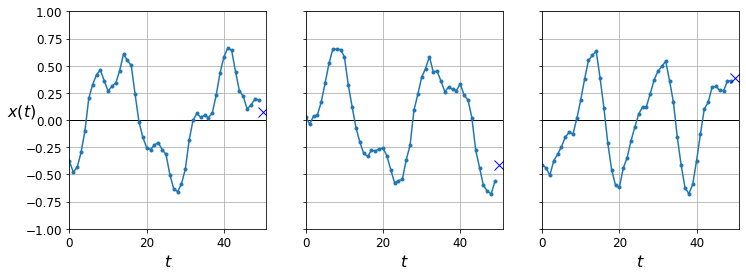

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

## 15.3.1 기준 성능

* RNN을 시작하기 전에 기준 성능을 몇 개 준비하는 것이 좋다. 그렇지 않으면 실제 모델보다 성능이 나쁠 때도 잘 작동한다고 생각할 수 있다.
 - 각 시계열의 마지막 값을 그대로 예측하는 것이다. 이를 순진한 예측(Naive Forecasting)이라고 한다.

In [7]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.02102486

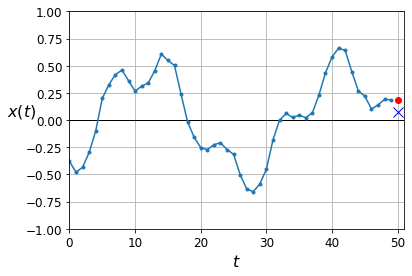

In [8]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

* 다른 방법은 완전 연결 네트워크를 사용하는 것이다.
 - 이 네트워크는 입력마다 1차원 특성 배열을 기대하기 떄문에 Flatten층을 추가해야 한다.
 - 시계열 값의 선형 조합으로 예측하기 위해 간단한 선형 회귀 모델을 사용

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1003 - val_loss: 0.0533
Epoch 2/20
219/219 [==============================] - 0s 951us/step - loss: 0.0386 - val_loss: 0.0269
Epoch 3/20
219/219 [==============================] - 0s 867us/step - loss: 0.0206 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 0s 968us/step - loss: 0.0133 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 844us/step - loss: 0.0104 - val_loss: 0.0095
Epoch 6/20
219/219 [==============================] - 0s 957us/step - loss: 0.0089 - val_loss: 0.0085
Epoch 7/20
219/219 [==============================] - 0s 995us/step - loss: 0.0080 - val_loss: 0.0076
Epoch 8/20
219/219 [==============================] - 0s 950us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 950us/step - loss: 0.0066 - val_loss: 0.0064
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0061 - 

In [10]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 762us/step - loss: 0.0041


0.004105030559003353

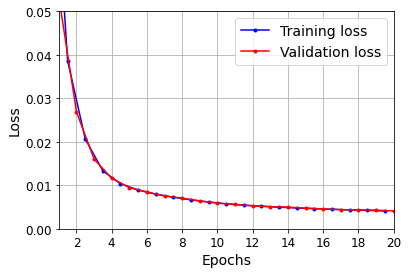

In [11]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

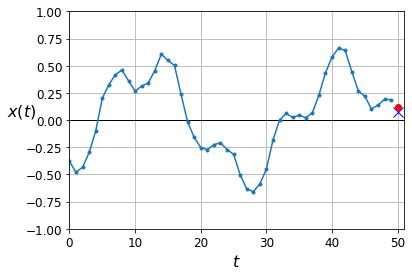

In [12]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 15.3.2 간단한 RNN 구현하기

* 가장 간단하게 만들 수 있는 RNN
 - 하나의 뉴런으로 이루어진 하나의 층을 가진다.
 - 순환 신경망은 어떤 길이의 타임 스텝도 처리할 수 있기 때문에 입력 시퀀스의 길이를 지정할 필요가 없다.
 - 기본적으로 SimpleRNN층은 하이퍼볼릭 탄젠트 활성화 함수를 사용한다.
 - 초기 상태를 0으로 설정하고, 첫 번째 타임 스텝과 함께 하나의 순환 뉴런으로 전달한다. 뉴런은 이 값의 가중치 합을 계산하고 하이퍼볼릭 탄젠트 활성화 함수를 적용하여 결과를 만들어 첫 번째 y를 출력한다. 기본 RNN에서는 이 출력이 새로운 상태가 된다.
* 기본 RNN의 순환 뉴런은 입력과 은닉 상태 차원마다 하나의 파라미터를 가지고 편향이 있다.

In [13]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0313 - val_loss: 0.0127
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0115
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0115
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0116

In [14]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0114


0.011417711153626442

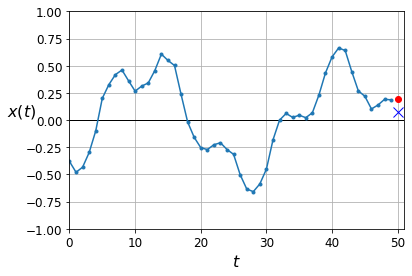

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

* 가중 이동 평균(Weighted Moving Average), 자동 회귀 누적 이동 평균(Autoregressive intergrated moving average)같이 시계열을 예측하는 다른 방법이 많다. 이런 방법 중 일부는 트렌드(Trend)나 계절성(Seasonality)을 제거해야 한다.
* 트렌드가 있는 데이터라면 시계열 데이터 준비 단계에서 트렌드를 삭제한다. 그리고 모델이 훈련하고 예측을 만들기 시작할 때 최종 트렌드를 다시 더한다.
* 계절성이 있는 시계열 데이터라면 매 타임 스텝의 값과 작년도 값의 차이를 계산하여 사용한다. (이를 차분, Differencing이라고 한다) 모델이 훈련되고 예측을 만든 후에 계절 패턴을 최종 예측에 더한다.

## 15.3.3 심층 RNN

* 셀을 여러 층 쌓는 것을 심층 RNN(Deep RNN)이라고 한다.
* 이 예시에서는 세 개의 SimpleRNN층을 사용한 심층 RNN

In [16]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0186 - val_loss: 0.0053
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0029 - val_lo

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0030


0.0030074839014559984

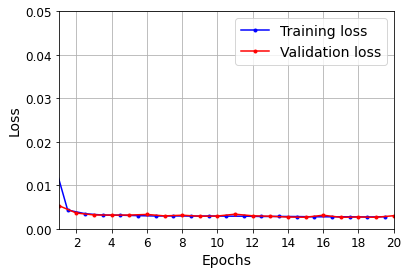

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

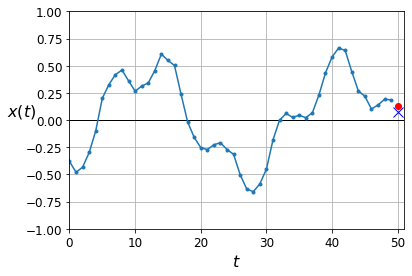

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

* 이 RNN에서는 한 타임 스텝에서 다음 타입 스텝으로 필요한 모든 정보를 나르기 위해 다른 순환 층의 은닉 상태를 주로 사용한다. 하지만 마지막 층의 은닉 상태는 크게 필요하지 않다.
* SimpleRNN층은 기본적으로 tanh 활성화 함수를 사용하기 때문에 예측된 값이 -1과 1사이에 놓여진다. 다른 활성화 함수를 사용하기 위해 출력층을 Dense층으로 바꾸는 경우가 많다.

In [20]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0943 - val_loss: 0.0093
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0063 - val_loss: 0.0049
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 10/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss:

 - 두 번째 층에서 return_sequences=True를 제거한다.
 - 마지막 출력층을 Dense층으로 바꾼다.

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0028


0.002836886327713728

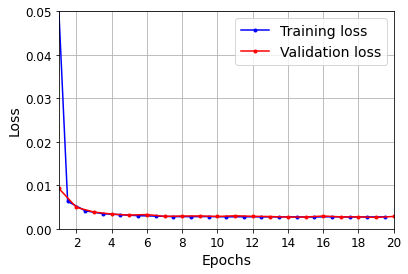

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

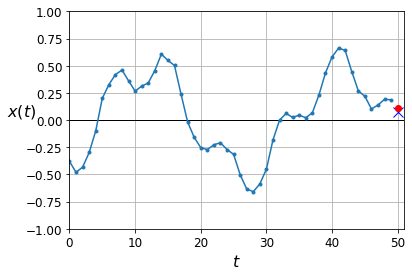

In [23]:

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 15.3.4 여러 타임 스텝 앞을 예측하기

* 다음 값 10개쯤 예측하고 싶다면 어떻게 해야할까?
 - 첫번째 방법은 이미 훈련된 모델을 사용하여 다음 값을 예측한 다음 이 값을 입력으로 추가하는 것이다.

In [24]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [29]:
Y_pred.shape

(1, 10, 1)

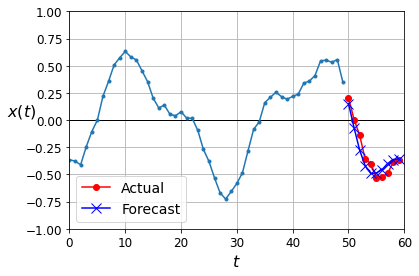

In [30]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

  - 두번째 방법은 RNN을 훈련하여 다음 값 10개를 한 번에 예측하는 것이다. 시퀀스-투-벡터 모델을 사용하지만 1개가 아니라 값 10개를 출력한다. 먼저 타깃을 다음 10개의 값이 담긴 벡터로 바꾸어야 한다.

In [31]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [34]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [35]:
Y_pred.shape

(2000, 10)

In [36]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.15178919

* naive predictions / simple linear 비교 

In [37]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.21619263

In [38]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1459 - val_loss: 0.0723
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0479
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0435 - val_loss: 0.0379
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0361 - val_loss: 0.0328
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0297
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0272
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0256
Epoch 8/20
219/219 [==============================] - 0s 986us/step - loss: 0.0255 - val_loss: 0.0245
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0244 - val_loss: 0.0235
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0235 - val_loss: 0.02

In [39]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

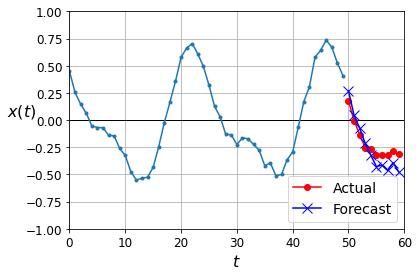

In [40]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

* 마지막 타임 스텝에서만 다음 값 10개를 예측하도록 모델을 훈련하는 대신 모든 타임 스텝에서 다음 값 10개를 예측하도록 모델을 훈련시켜 더 개선할 수 있다.
 - 시퀀스-투-벡터 RNN을 시퀀스-투-시퀀스 RNN으로 바꿀 수 있다
 - 이 방식의 장점은 마지막 타임 스텝에서의 출력 뿐만 아니라  모든 타임 스텝에서 RNN 출력에 대한 항이 손실에 포함된다는 의미이다.
 - 더 많은 오차 그레이디언트가 모델로 흐른다는 뜻이고, 각 타임 스텝의 출력에서 그레이디언트가 흐를 수 있다.
 - 이는 훈련을 안정적으로 만들고 훈련 속도를 높인다.

In [41]:
#타임 스텝마다 10차원 벡터를 담고 있는 타킷 시퀀스 준비
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [42]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [44]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0523 - last_time_step_mse: 0.0415 - val_loss: 0.0460 - val_last_time_step_mse: 0.0333
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0370 - last_time_step_mse: 0.0238 - val_loss: 0.0360 - val_last_time_step_mse: 0.0246
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0324 - last_time_step_mse: 0.0202 - val_loss: 0.0308 - val_last_time_step_mse: 0.0194
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0294 - last_time_step_mse: 0.0174 - val_loss: 0.0279 - val_last_time_step_mse: 0.0159
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0309 - last_time_step_mse: 0.0201 - val_loss: 0.0287 - val_last_time_step_mse: 0.0179
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0273 - last_time_step_mse: 0.0154 - val_loss: 0.0263 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [=======

 - 이 모델을 시퀀스-투-시퀀스 모델로 바꾸려면 모든 순환 층에 'return_sequences=True'를 지정 해야한다.
 - 케라스는 이런 목적을 위해 TimeDistributed층을 제공한다.
 - 이 층은 다른 층을 감싸서 입력 시퀀스의 모든 타임 스텝에 이를 적용한다.
 - 각 타임 스텝을 별개의 샘플터럼 다루도록 입력의 크기를 바꾸어 이를 효과적으로 수행한다.
 - 입력을 [배치 크기, 타임 스텝 수, 입력 차원]에서 [배치 크기 X 타임 스텝 수, 입력 차원]크기로 바꾼다.

In [45]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

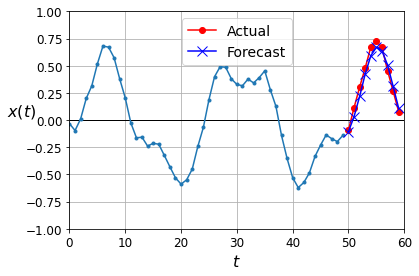

In [46]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

* 시계열을 예측할 때 오차 막대(Error Bar)를 사용하는 것이 유용하다. 이에 대한 효율적인 도구는 MC드롭아웃이다. 각 메모리 셀에 드롭아웃 층을 추가하여 입력과 은닉 상태를 드롭아웃한다. 훈련이 끝난 후 새로운 시계열을 예측하기 위해서 이 모델을 여러 번 사용해 각 타임 스텝에서 예측의 평균과 표준편차를 계산한다.

# 15.4 긴 시퀀스 다루기

* 긴 시퀀스로 RNN을 훈련하려면 많은 타음 스텝에 걸쳐 실행해야 하므로 펼친 RNN이 매우 깊은 네트워크가 된다.
* 보통 심층 신경망처럼 그레이디언트 소실과 폭주 문제가 생길 수 있다.
* 훈련하는 데 아주 오랜 시간이 걸리거나 훈련이 불안정할 수 있다.
* RNN이 긴 시퀀스를 처리할 때 입력의 첫 부분을 조금씩 잊어버린다.

## 15.4.1 불안정한 그레이디언트 문제와 싸우기

* 불안정한 그레이디언트 문제를 완화하기 위해 심층 신경망에서 사용했던 많은 기법을 RNN에서도 사용할 수 있다.
* 좋은 가중치 초기화, 빠른 옵티마이저, 드롭아웃 등이 있다.
* 수렴하지 않는 활성화 함수는 큰 도움이 되지 않는다.
 - 첫번째 타임 스텝에서 출력을 조금 증가시키는 방향으로 가중치를 업데이트한다고 가정하면, 동일한 가중치가 모든 타임 스텝에서 사용되기 때문에 모든 출력이 증가할 수 있다. 이런 식으로 출력이 폭주 할 수 있다. 따라서 수렴하지 않는 활성화 함수는 이를 막지 못한다.
 - 작은 학습율을 사용하거나 하이퍼볼릭 탄젠트 같은 수렴하는 활성화 함수를 사용함으로써 위험을 감소시킬 수 있다.
* 그레이디언트 자체도 폭주할 수 있는데, 훈련이 불안정하다고 느껴지면 그레이디언트의 크기를 모니터링하고 그레이디언트 클리핑(Gradient Clipping)을 사용하는 것이 좋다.
* 배치 정규화는 메모리 셀에 배치 정규화 층을 추가하여 타임 스텝마다 적용할 수 있다.(현재 타임 스텝의 입력과 이전 스텝의 은닉상태 모두에)
 - 하지만 입력이나 은닉 상태의 실제 스케일과 이동에 상관없이 동일한 파라미터를 가진 배치 정규화가 타임 스텝마다 사용될 것이다.
 - 순환 층 안이 아니라 순환 층 사이에 적용했을 때 없는 것보다 조금 낫다.
 - 케라스에서는 BatchNormalization층이 있다.
* RNN에서 잘 맞는 다른 종류의 정규화는 층 정규화(Layer Normalization)이다.
 - 배치 정규화와 매우 비슷하지만 배치 차원에 대해 정규화하는 대신 특성 차원에 대해 정규화한다.
 - 샘플에 독립적으로 타임 스텝마다 동적으로 필요한 통계를 계산할 수 있다는 장점이 있다.
 - 이는 훈련과 테스트에서 동일한 방식으로 작동한다는 것을 의미한다.

In [47]:
# 배치 정규화 사용한 심층 RNN
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 12ms/step - loss: 0.1430 - last_time_step_mse: 0.1299 - val_loss: 0.0991 - val_last_time_step_mse: 0.0889
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0516 - last_time_step_mse: 0.0424 - val_loss: 0.0554 - val_last_time_step_mse: 0.0456
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0450 - last_time_step_mse: 0.0355 - val_loss: 0.0443 - val_last_time_step_mse: 0.0341
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0403 - last_time_step_mse: 0.0295 - val_loss: 0.0386 - val_last_time_step_mse: 0.0276
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0367 - last_time_step_mse: 0.0249 - val_loss: 0.0350 - val_last_time_step_mse: 0.0241
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0338 - last_time_step_mse: 0.0215 - val_loss: 0.0330 - val_last_time_step_mse: 0.0217
Epoch 7/20
219/219 [==

In [48]:
# 층 정규화 사용한 심층 RNN
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [49]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))


Epoch 1/20
219/219 [==============================] - 6s 25ms/step - loss: 0.1485 - last_time_step_mse: 0.1296 - val_loss: 0.0673 - val_last_time_step_mse: 0.0567
Epoch 2/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0604 - last_time_step_mse: 0.0494 - val_loss: 0.0556 - val_last_time_step_mse: 0.0448
Epoch 3/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0530 - last_time_step_mse: 0.0419 - val_loss: 0.0515 - val_last_time_step_mse: 0.0404
Epoch 4/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0482 - last_time_step_mse: 0.0369 - val_loss: 0.0466 - val_last_time_step_mse: 0.0354
Epoch 5/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0441 - last_time_step_mse: 0.0324 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 6/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0409 - last_time_step_mse: 0.0289 - val_loss: 0.0389 - val_last_time_step_mse: 0.0271
Epoch 7/20
219/219 [==

* 개인 RNN Class 만들기

In [50]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [51]:
model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 17ms/step - loss: 0.1704 - last_time_step_mse: 0.1589 - val_loss: 0.0669 - val_last_time_step_mse: 0.0548
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0609 - last_time_step_mse: 0.0481 - val_loss: 0.0555 - val_last_time_step_mse: 0.0437
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0524 - last_time_step_mse: 0.0396 - val_loss: 0.0492 - val_last_time_step_mse: 0.0372
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0470 - last_time_step_mse: 0.0338 - val_loss: 0.0444 - val_last_time_step_mse: 0.0320
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0431 - last_time_step_mse: 0.0296 - val_loss: 0.0416 - val_last_time_step_mse: 0.0284
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0402 - last_time_step_mse: 0.0262 - val_loss: 0.0386 - val_last_time_step_mse: 0.0247
Epoch 7/20
219/219 [==

## 15.4.2 단기 기억 문제 해결하기

* RNN을 거치면서 데이터가 변환되므로 일부 정보는 매 훈련 스텝 후 사라진다.
* 이 문제를 해결하기 위해 장기 메모리를 가진 여러 종류의 셀이 연구되었다.

* LSTM
<img src = "images/15_images/lstm.PNG">

 - 장단기 메모리(Long Short Term Memory)은 훈련이 빠르게 수렴하고, 데이터에 있는 장기간의 의존성을 감지할 수 있다.
 - LSTM 셀은 상태가 두 개의 벡터 $h_{(t)}$ 와 $c_{(t)}$로 나뉜다.
   - $h_{(t)}$를 단기 상태(Short-Term State)
   - $c_{(t)}$를 장기 상태(Long-Term State)
 - 핵심 아이디어는 네트워크가 장기 상태에 저장할 것, 버릴 것, 읽어들일 것을 학습하는 것이다.
 - 장기 기억 $c_{(t-1)}$은 네트워크를 왼쪽에서 오른쪽으로 관통하면서 삭제 게이트(Forget Gate)를 지나 일부 기억을 잃고, 그런 다음 덧셈 연산으로 새로운 기억 일부를 추가한다.(입력 게이트, Input Gate에서 선택한 기억을 추가)
 - 만들어진 장기 기억$c_{(t)}$은 다른 추가 변환 없이 바로 출력으로 보내진다.
 - 그래서 타임 스텝마다 일부 기억이 삭제되고 일부 기억이 추가된다.
 - 또한 덧셈 연산 후 이 장기 상태가 복사되어 tanh함수로 전달된다.
 - 그런 다음 이 결과는 출력 게이트(Output gate)에 의해 걸러진다.
 - 이는 단기 상태 $h_{(t)}$를 만든다.


* 새로운 기억이 들어오는 곳과 게이트의 작동 방식
 - 주 층은 $g_{(t)}$를 출력하는 층. 이 층은 현재 입력 $x_{(t)}$와 이전의 단기 상태 $h_{(t-1)}$을 분석하는 일반적인 역할을 담당한다. LSTM에서는 이 층의 출력이 곧 바로 나가지 않고, 대신 장기 상태에 가장 중요한 부분이 저장된다.(나머지는 버린다.)
 - 세 개의 다른 층은 게이트 제어가(Gate Controller)이다. 이들은 로지스틱 함수를 사용하기 때문에 출력의 범위가 0에서 1이다. 이들의 출력은 원소별 곱셈 연산으로 주입되어, 0을 출력하면 게이트를 닫고 1을 출력하면 게이트를 연다.
 - 삭제 게이트는 장기 상태의 어느 부분이 삭제되어야 하는지 제어한다.
 - 입력 게이트는 $g_{(t)}$의 어느 부분이 장기 상태에 더해져야 하는지 제어한다.
 - 마지막으로 출력 게이트는 장기 상태의 어느 부분을 읽어서 이 타임 스텝의 $h_{(t)}$와 $y_{(t)}$로 출력해야 하는지 제어한다

* 즉, LSTM셀은 중요한 입력을 인식하고(입력 게이트의 역할), 장기 상태에 저장하고, 필요한 기간 동안 이를 보존하고(삭제 게이트의 역할), 필요할 때마다 이를 추출하기 위해 학습한다.
* 그러므로 LSTM셀은 시계열, 긴 텍스트, 오디오 녹음 등에서 장기 패턴을 잡아내는데 좋은 성과를 낸다.

In [52]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0790 - last_time_step_mse: 0.0629 - val_loss: 0.0561 - val_last_time_step_mse: 0.0379
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0480 - last_time_step_mse: 0.0261 - val_loss: 0.0412 - val_last_time_step_mse: 0.0188
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0380 - last_time_step_mse: 0.0163 - val_loss: 0.0354 - val_last_time_step_mse: 0.0148
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0339 - last_time_step_mse: 0.0140 - val_loss: 0.0325 - val_last_time_step_mse: 0.0134
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0317 - last_time_step_mse: 0.0129 - val_loss: 0.0307 - val_last_time_step_mse: 0.0123
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0302 - last_time_step_mse: 0.0121 - val_loss: 0.0292 - val_last_time_step_mse: 0.0113
Epoch 7/20
219/219 [==

In [53]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0239 - last_time_step_mse: 0.0088


[0.02393246255815029, 0.008846688084304333]

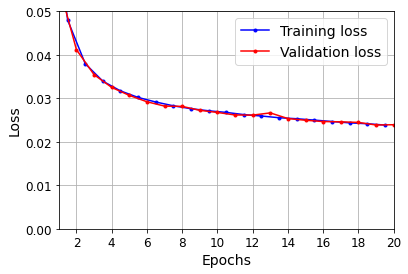

In [54]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [55]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

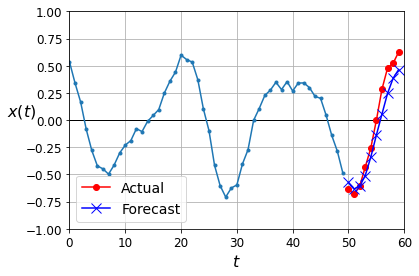

In [56]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

* 핍홀 연결
 - 핍홀 연결(Peephole Connection)이라 부르는 추가적인 연결이 있는 LSTM변종이다.
 - 이전 장기 기억 상태가 삭제 게이트와 입력 게이트의 제어기에 입력으로 추가된다.
 - 이는 성능을 향상시키는 경우가 많지만, 핍홀 여부에 따라 어떤 종류의 작업이 좋아지는지 명확하지 않다.

* GRU 셀
 - 게이트 순환 유닛(Gated Recurrent Unit, GRU)
 - 두 상태 벡터가 하나의 벡터 $h_{(t)}$로 합쳐졌다.
 - 하나의 게이트 제어기 $z_{(t)}$가 삭제 게이트와 입력 게이트를 모두 제어한다. 게이트 제어기가 1을 출력하면 삭제 게이트가 열리고 입력게이트가 닫힌다.
 - 게이트 제어기가 0을 출력하면 그 반대가 된다.
 - 즉, 기억이 저장될 때마다 저장될 위치가 먼저 삭제된다.
 - 출력 게이트가 없다. 즉 전체 상태 벡터가 매 타임 스텝마다 출력된다. 그러나 이전 상태의 어느 부분이 주 층에 노출될지 제어하는 새로운 게이트 제어기가 있다.
 
* GRU셀은 keras.layers.GRU층을 제공한다.
 - 100 타임 스텝 이상의 시퀀스에서 장기 패턴을 학습하는 데 어려움이 있다. 이 문제를 해결하는 한 가지 방법은 1D 합성곱 층을 사용해 입력 시퀀스를 짧게 줄이는 것이다.
 <img src ="images/15_images/gru.PNG">

In [57]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0773 - last_time_step_mse: 0.0682 - val_loss: 0.0543 - val_last_time_step_mse: 0.0433
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0501 - last_time_step_mse: 0.0394 - val_loss: 0.0466 - val_last_time_step_mse: 0.0360
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0451 - last_time_step_mse: 0.0342 - val_loss: 0.0440 - val_last_time_step_mse: 0.0328
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0421 - last_time_step_mse: 0.0306 - val_loss: 0.0404 - val_last_time_step_mse: 0.0283
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0386 - last_time_step_mse: 0.0263 - val_loss: 0.0356 - val_last_time_step_mse: 0.0228
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0332 - last_time_step_mse: 0.0181 - val_loss: 0.0309 - val_last_time_step_mse: 0.0153
Epoch 7/20
219/219 [==

In [58]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0234 - last_time_step_mse: 0.0102


[0.023379744961857796, 0.010247216559946537]

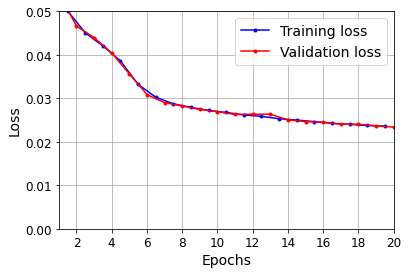

In [59]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [60]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

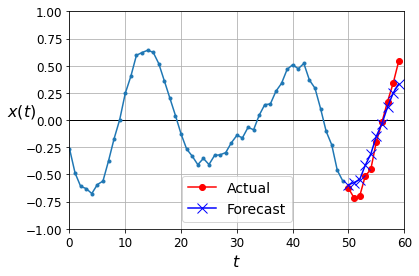

In [61]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

* 1D 합성곱 층을 사용해 시퀀스 처리하기
 - 1D 합성곱 층이 몇 개의 커널을 시퀀스 위를 슬라이딩 하여 커널마다 1D 특성 맵을 출력한다.
 - 각 커널은 매우 짧은 하나의 순차 패턴을 감지하도록 학습된다.
 - 10개의 커널을 사용하면 이 층의 출력은 10개의 1차원 시퀀스로 구성된다. 또는 이 출력을 10차원 시퀀스 하나로 볼 수 있다.
 - 이는 순환 층과 1D 합성곱 층을 섞어서 신경망을 구성할 수 있다.
   - 스트라이드 1과 "same" 패딩으로 1D 합성곱 층을 사용하면 출력 시퀀스의 길이는 입력 시퀀스와 같다.
   - "valid" 패딩과 1보다 큰 스트라이드를 사용하면 출력 시퀀스는 입력 시퀀스보다 짧아진다. 
   - 스트라이드 2를 사용해 입력 시퀀스를 두 배로 다운샘플링하는 1D합성곱 층으로 시작하는 것이 다르다.
 - 커널 크기가 스트라이드보다 크므로 모든 입력을 사용하여 이 층의 출력을 계산한다.
 - 따라서 모델이 중요하지 않은 세부 사항은 버리고 유용한 정보를 보존하도록 학습할 수 있다.
 - 합성곱 층으로 시퀀스 길이를 줄이면 GRU 층이 더 긴 패턴을 감지하는데 도움이 된다.

In [62]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0720 - last_time_step_mse: 0.0642 - val_loss: 0.0503 - val_last_time_step_mse: 0.0417
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0421 - last_time_step_mse: 0.0340 - val_loss: 0.0360 - val_last_time_step_mse: 0.0276
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0328 - last_time_step_mse: 0.0235 - val_loss: 0.0297 - val_last_time_step_mse: 0.0191
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0276 - last_time_step_mse: 0.0168 - val_loss: 0.0259 - val_last_time_step_mse: 0.0148
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0250 - last_time_step_mse: 0.0139 - val_loss: 0.0244 - val_last_time_step_mse: 0.0134
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0235 - last_time_step_mse: 0.0125 - val_loss: 0.0228 - val_last_time_step_mse: 0.0120
Epoch 7/20
219/219 [==

* WAVENET
 - 이 네트워크는 층마다 팽창 비율을 두 배로 늘리는 1D 합성곱 층을 쌓는다.
 - 첫 번째 합성곱 층이 한번에 2개 타임 스텝만 바라본다. 다음 층은 4개의 타임 스텝을 보고, 다음은 8개의 타임 스텝을 보는 식이다.
 - 이런 식으로 하위 층으로 단기 패턴을 학습하고 상위 층은 장기 패턴을 학습한다.
 - 팽창 비율을 두 배로 늘린 덕분에 네트워크는 아주 긴 시퀀스를 매우 효율적으로 처리할 수 있다.

In [63]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0690 - last_time_step_mse: 0.0548 - val_loss: 0.0374 - val_last_time_step_mse: 0.0232
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0339 - last_time_step_mse: 0.0205 - val_loss: 0.0307 - val_last_time_step_mse: 0.0173
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0291 - last_time_step_mse: 0.0163 - val_loss: 0.0284 - val_last_time_step_mse: 0.0159
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0267 - last_time_step_mse: 0.0143 - val_loss: 0.0260 - val_last_time_step_mse: 0.0135
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0252 - last_time_step_mse: 0.0131 - val_loss: 0.0248 - val_last_time_step_mse: 0.0129
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0242 - last_time_step_mse: 0.0121 - val_loss: 0.0238 - val_last_time_step_mse: 0.0121
Epoch 7/20
219/219 [========